In [2]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors
from scipy.integrate import trapezoid
from matplotlib.patches import Rectangle

mp.verbosity(1)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

In [3]:
resolution = 100
design_region_resolution = int(resolution)

design_region_x_width  = 1   #100 nm
design_region_y_height = 1   #100 nm
design_region_z_height = 0.03  #20 nm or 10nm

pml_size = 1.0
pml_layers = [mp.PML(pml_size,direction=mp.Z)]

Sz_size = 0.6
Sx = design_region_x_width
Sy = design_region_y_height 
Sz = 2 * pml_size + design_region_z_height + Sz_size
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([1.55])     # wavelengths = np.array([1.5 ,1.55, 1.6])
frequencies = np.array([1 / 1.55])

nf = 1                 #3 #wavelengths Number

minimum_length = 0.01  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e      # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

Source_distance = -0.2

fcen   = 1 / 1.55
width  = 0.2  
fwidth = width * fcen
source_center = mp.Vector3(0,0,Source_distance)  
source_size   = mp.Vector3(design_region_x_width, design_region_y_height, 0)
src    = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]   

Nx = int(design_region_resolution * design_region_x_width) + 1
Ny = int(design_region_resolution * design_region_y_height) + 1
Nz = 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, Ag, grid_type="U_MEAN")
design_region    = mpa.DesignRegion(
            design_variables,
            volume=mp.Volume(
            center=mp.Vector3(0,0,0),
            size=mp.Vector3(design_region_x_width, design_region_y_height, design_region_z_height),
            ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_x_width,
        design_region_y_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    projected_field = (npa.fliplr(projected_field) + projected_field) / 2
    projected_field = (npa.flipud(projected_field) + projected_field) / 2  # left-right symmetry    
    
    return projected_field.flatten()


geometry = [mp.Block(center=design_region.center, size=design_region.size, material=design_variables)]

kpoint = mp.Vector3()
sim = mp.Simulation(
    cell_size        = cell_size,
    boundary_layers  = pml_layers,
    geometry         = geometry,
    sources          = source,
    default_material = Air,
    k_point          = kpoint,
    symmetries       = [mp.Mirror(direction=mp.X)],
    resolution       = resolution,
    extra_materials  = [Ag],       # Introducing metal complex terms
)
#---------------------------------------------------------------------------------------------------#


#-----------------[4]---------------------------------#
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,0.01)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=True)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = npa.abs(fields_x) ** 2
    ET_y = npa.abs(fields_y) ** 2
    ET_z = npa.abs(fields_z) ** 2
    ET = npa.sqrt( npa.mean(ET_x) + npa.mean(ET_y) + npa.mean(ET_z) )  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

In [ ]:
eps_data = opt.sim.get_array(component=mp.Dielectric,
                         center=mp.Vector3(),
                         size=mp.Vector3(1, 1, 0))

In [3]:
evaluation_history = np.load('Post_evaluation_history.npy')
evaluation_history_emp = np.load('FOM_ET_empty.npy')
beta_A  = np.load("Post_beta_scale_array.npy")
eta_A   = np.load("Post_eta_i_array.npy")
cur_A   = np.load("Post_cur_beta_array.npy")
x_A     = np.load("Post_x_array.npy")

In [4]:
print(cur_A )
print(beta_A)

16384
2


FOM_FINAL = 80.95442365952789


<Figure size 640x480 with 0 Axes>

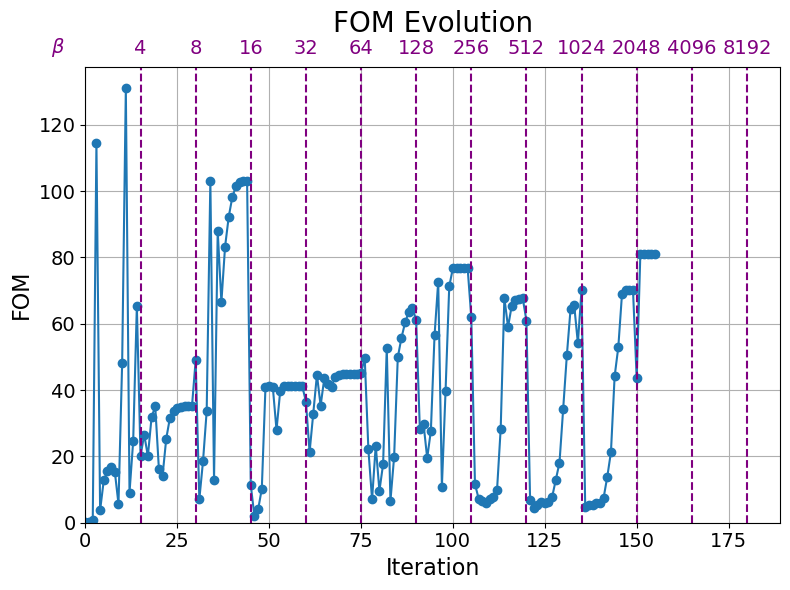

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 尺寸與字體大小設定 =====
FIGSIZE        = (8, 6)
TICK_FONTSIZE  = 14   # 座標軸刻度字級
LABEL_FONTSIZE = 16   # x/y 標籤字級
TITLE_FONTSIZE = 20   # 標題字級
BETA_FONTSIZE  = 14   # β 文字字級
ANNOT_FONTSIZE = 14   # β=4,8,16... 標註字級

# ===== 資料處理 =====
plt.figure()
evaluation_history_Correction = evaluation_history / evaluation_history_emp
print("FOM_FINAL =", evaluation_history_Correction[-1])
#print("FOM_FINAL =", evaluation_history_Correction[165])

# ===== 繪圖（面向物件 API，比較好控管字型）=====
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(evaluation_history_Correction, "o-")

value = 4
for i in range(1, 13):
    x_pos = 15 * i
    ax.axvline(x=x_pos, color='purple', linestyle='--')

    # 把數字畫在 x 軸上方一點點（使用 x 軸的 transform）
    ax.text(
        x_pos, 1.02, f"{value}",
        color='purple', ha='center', va='bottom', fontsize=ANNOT_FONTSIZE,
        transform=ax.get_xaxis_transform(), clip_on=False
    )
    value *= 2

ax.grid(True)

# 軸範圍
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# 標題與座標軸標籤字體大小
ax.set_title("FOM Evolution", fontsize=TITLE_FONTSIZE, pad=25)
ax.set_xlabel("Iteration", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("FOM", fontsize=LABEL_FONTSIZE)

# 座標軸刻度字體大小
ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# β 文字：用座標軸百分比座標，固定在左上方
ax.text(-0.05, 1.03, r'$\beta$', color='purple', fontsize=BETA_FONTSIZE,
        transform=ax.transAxes)

plt.tight_layout()
plt.show()
plt.close()


FOM_FINAL = 80.95442365952789


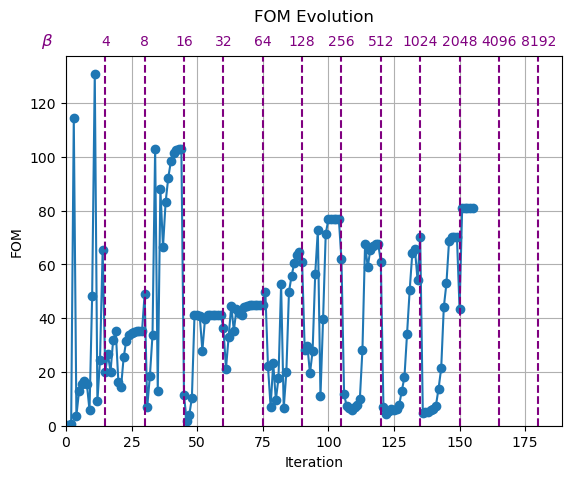

In [6]:
plt.figure()
evaluation_history_Correction = evaluation_history / evaluation_history_emp
print("FOM_FINAL =",evaluation_history_Correction[-1])
plt.plot(evaluation_history_Correction, "o-")

value = 4
for i in range(1, 13):
    x_pos = 15 * i
    plt.axvline(x=x_pos, color='purple', linestyle='--')

    plt.text(x_pos, 1.02,  # 大於1即可在標題之上
             f"{value}", color='purple',
             ha='center', va='bottom', fontsize=10,
             transform=plt.gca().get_xaxis_transform(),
             clip_on=False)
    value *= 2

plt.grid(True)
plt.title("FOM Evolution", pad=25)  
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.text(plt.xlim()[1]*(-0.05), plt.ylim()[1]*1.03, r'$\beta$', color='purple', fontsize=12)
plt.show()
plt.close()

FOM_FINAL = 156.8786644849575


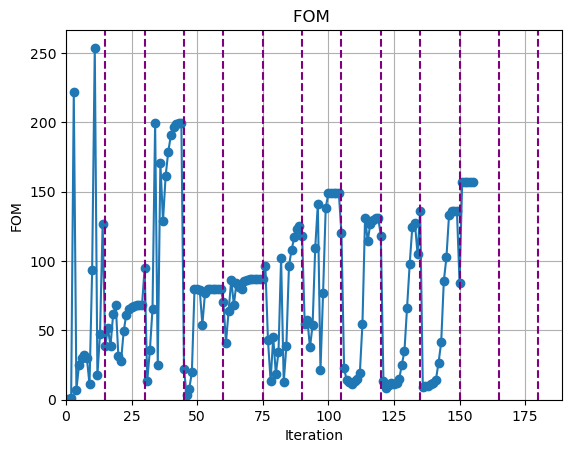

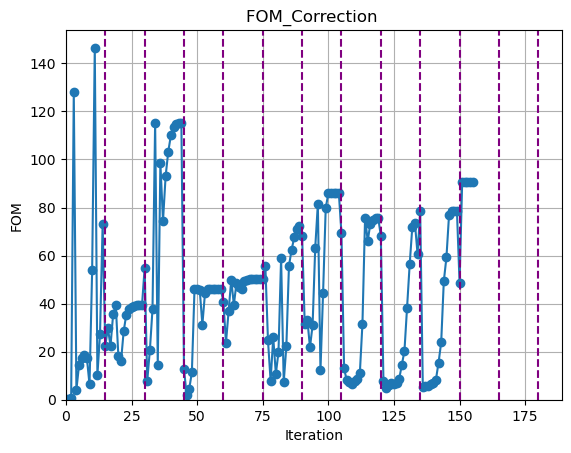

In [7]:
plt.figure()
plt.plot(evaluation_history, "o-")
print("FOM_FINAL =",evaluation_history[-1])
for i in range(1,13):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.title("FOM ")
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()
plt.close()


plt.figure()
evaluation_history_Correction = evaluation_history / (np.sqrt(3))
plt.plot(evaluation_history_Correction, "o-")

for i in range(1,13):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.title("FOM_Correction ")
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()
plt.close()

     block, center = (0,0,0)
          size (1,1,0.03)
          axes (1,0,0), (0,1,0), (0,0,1)


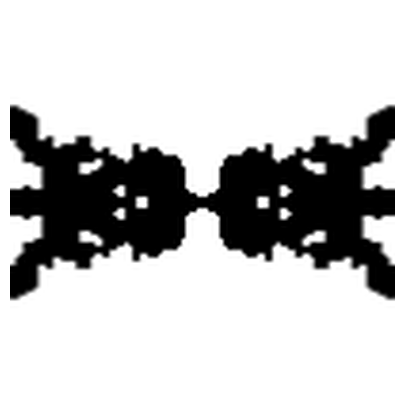

In [8]:
opt.update_design([mapping(x_A, eta_A, cur_A)])  # cur_beta/beta_scale is the final beta in the optimization.
plt.figure(figsize=(5,5))
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    output_plane = mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(design_region_x_width, design_region_y_height, 0))
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()
plt.close()

In [9]:
Ex_xz = np.load('DFT_GAS/Dft_GAS_Ex_xz.npy')
Ey_xz = np.load('DFT_GAS/Dft_GAS_Ey_xz.npy')
Ez_xz = np.load('DFT_GAS/Dft_GAS_Ez_xz.npy')
Ex_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xz.npy')
Ey_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xz.npy')
Ez_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xz.npy')

Ex_yz = np.load('DFT_GAS/Dft_GAS_Ex_yz.npy')
Ey_yz = np.load('DFT_GAS/Dft_GAS_Ey_yz.npy')
Ez_yz = np.load('DFT_GAS/Dft_GAS_Ez_yz.npy')
Ex_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_yz.npy')
Ey_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_yz.npy')
Ez_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_yz.npy')

Ex_xyz1 = np.load('DFT_GAS/Dft_GAS_Ex_xyz1.npy')
Ey_xyz1 = np.load('DFT_GAS/Dft_GAS_Ey_xyz1.npy')
Ez_xyz1 = np.load('DFT_GAS/Dft_GAS_Ez_xyz1.npy')
Ex_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xyz1.npy')
Ey_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xyz1.npy')
Ez_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xyz1.npy')

Ex_xyz0 = np.load('DFT_GAS/Dft_GAS_Ex_xyz0.npy')
Ey_xyz0 = np.load('DFT_GAS/Dft_GAS_Ey_xyz0.npy')
Ez_xyz0 = np.load('DFT_GAS/Dft_GAS_Ez_xyz0.npy')
Ex_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xyz0.npy')
Ey_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xyz0.npy')
Ez_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xyz0.npy')

Ex_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ex_xyz0.npy')
Ey_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ey_xyz0.npy')
Ez_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ez_xyz0.npy')


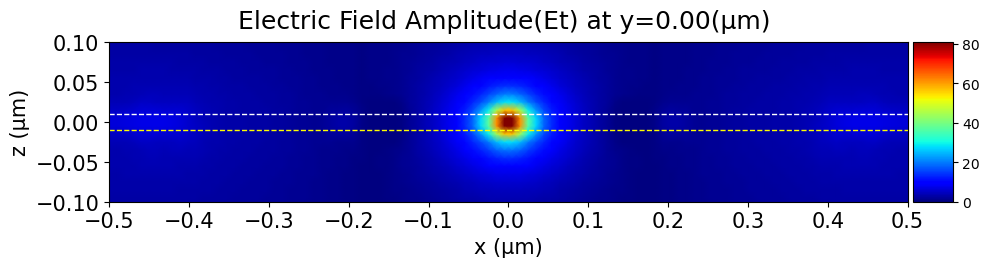

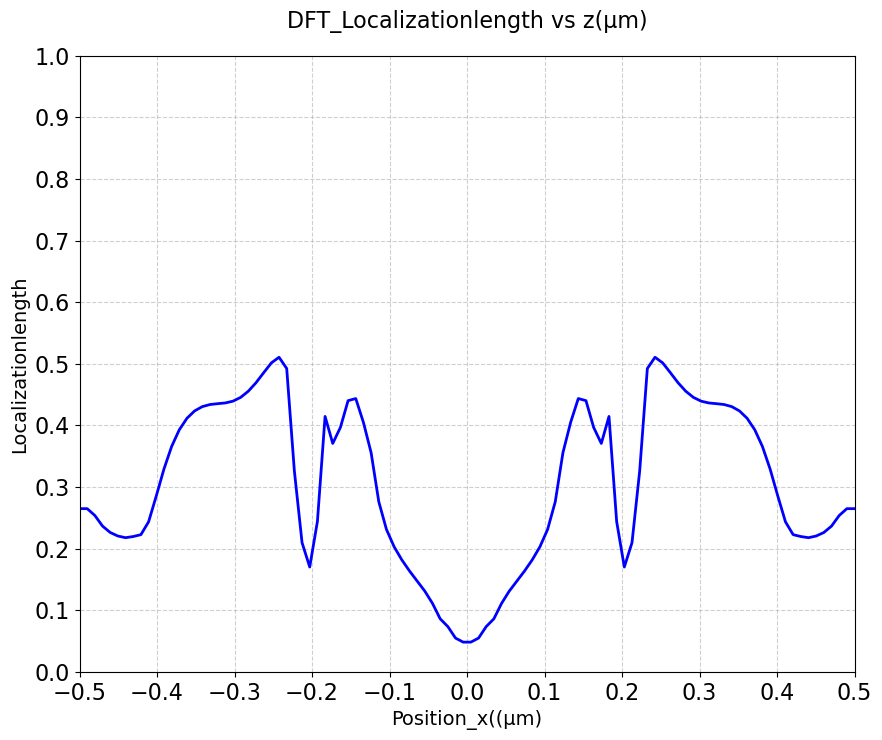

0.048051142305236966


In [10]:
amplitude_xz       = np.sqrt(np.abs(Ex_xz)**2 + np.abs(Ey_xz)**2 + np.abs(Ez_xz)**2)
amplitude_xz_log   = np.log(amplitude_xz)
amplitude_xz_sqrt  = np.sqrt(amplitude_xz) 

amplitude_xz_empty    = np.sqrt(np.abs(Ex_xz_empty)**2 + np.abs(Ey_xz_empty)**2 + np.abs(Ez_xz_empty)**2)
amplitude_xz_enhance  = amplitude_xz / amplitude_xz_empty
amplitude_xz_enhance_log  = np.log(amplitude_xz_enhance) 
amplitude_xz_enhance_sqrt = np.sqrt(amplitude_xz_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_xz.shape[0])
z = np.linspace(-(Sz-2 * pml_size)/2,(Sz-2 * pml_size)/2,Ey_xz.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

plt.axhline(y= 0.01, color="white" , linestyle="--", linewidth=1, label="y = 0.01 μm")
plt.axhline(y=-0.01, color="yellow", linestyle="--", linewidth=1, label="y = -0.01 μm")

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        z,
        np.transpose(amplitude_xz_enhance),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_xz_enhance),
    )
plt.gca().set_aspect("equal")
plt.title("Electric Field Amplitude(Et) at y=0.00(μm) ", fontsize=18, pad=10)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("z (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.1, 0.1)
plt.yticks(np.arange(-0.1, 0.1 + 0.000001, 0.05), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()

################################################################################################################
Et_xyz0_4 = np.abs(amplitude_xz  )**4
Et_xyz0_2 = np.abs(amplitude_xz  )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
z = np.linspace(-(Sz-2*pml_size)/2, (Sz-2*pml_size)/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[0]):
    Ey_4_I = trapezoid(Et_xyz0_4[i,:],x=z)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[0]):
    Ey_2_I = trapezoid(Et_xyz0_2[i,:],x=z)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


plt.figure(figsize=(10, 8))  # 調整圖的大小
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs z(μm)", fontsize=16, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)  # 增加網格線
plt.plot(x, L, color="blue", linewidth=2, label="Mean Ey over y-axis")
plt.xlim(-0.5,0.5)
plt.tick_params(axis='x',labelsize=16)
plt.xticks(np.arange(-0.5,0.5+0.000001 , 0.1))
plt.ylim(0,1)
plt.tick_params(axis='y',labelsize=16)
plt.yticks(np.arange(0,1+0.000001 , 0.1))
plt.xlabel("Position_x((μm)" ,fontsize=14)
plt.ylabel("Localizationlength",fontsize=14)
plt.show()
plt.close()

print(L[51])






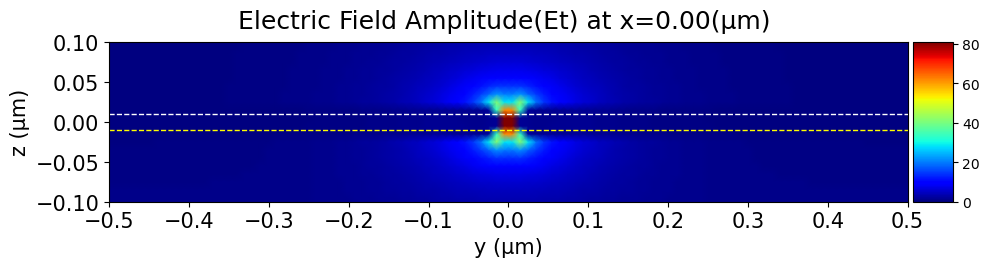

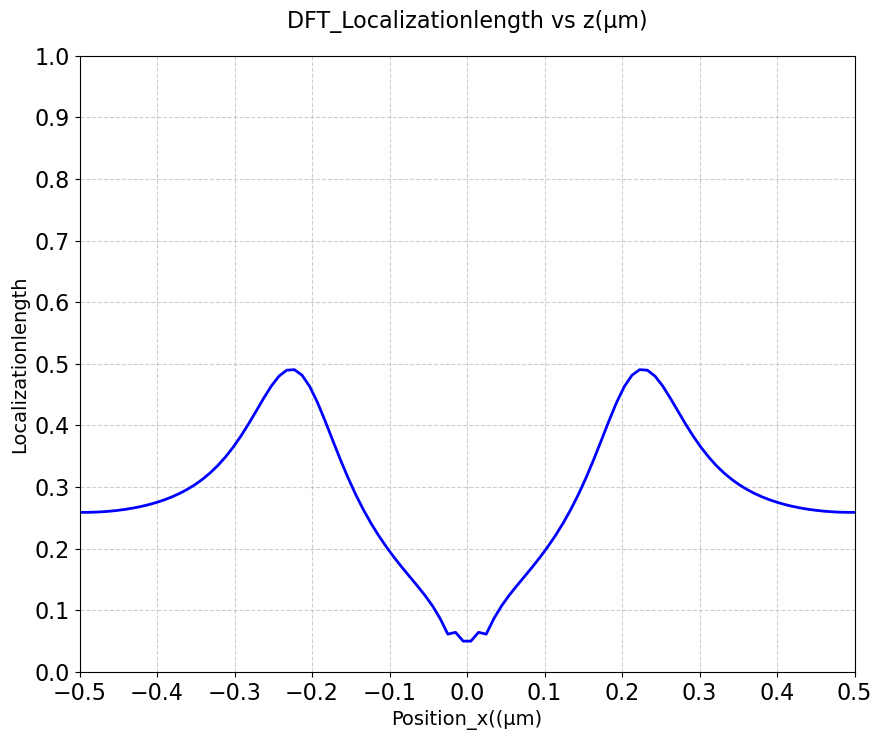

In [11]:
amplitude_yz       = np.sqrt(np.abs(Ex_yz)**2 + np.abs(Ey_yz)**2 + np.abs(Ez_yz)**2)
amplitude_yz_log   = np.log(amplitude_yz)
amplitude_yz_sqrt  = np.sqrt(amplitude_yz) 

amplitude_yz_empty    = np.sqrt(np.abs(Ex_yz_empty)**2 + np.abs(Ey_yz_empty)**2 + np.abs(Ez_yz_empty)**2)
amplitude_yz_enhance  = amplitude_yz / amplitude_yz_empty
amplitude_yz_enhance_log  = np.log(amplitude_yz_enhance) 
amplitude_yz_enhance_sqrt = np.sqrt(amplitude_yz_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_yz.shape[0])
z = np.linspace(-(Sz-2 * pml_size)/2,(Sz-2 * pml_size)/2,Ey_yz.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

plt.axhline(y= 0.01, color="white" , linestyle="--", linewidth=1, label="y = 0.01 μm")
plt.axhline(y=-0.01, color="yellow", linestyle="--", linewidth=1, label="y = -0.01 μm")

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        z,
        np.transpose(amplitude_yz_enhance),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_yz_enhance),
    )
plt.gca().set_aspect("equal")
plt.title("Electric Field Amplitude(Et) at x=0.00(μm) ", fontsize=18, pad=10)
plt.xlabel("y (μm)", fontsize=15)
plt.ylabel("z (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.1, 0.1)
plt.yticks(np.arange(-0.1, 0.1 + 0.000001, 0.05), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()

################################################################################################################
Et_xyz0_4 = np.abs(amplitude_yz  )**4
Et_xyz0_2 = np.abs(amplitude_yz  )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
z = np.linspace(-(Sz-2*pml_size)/2, (Sz-2*pml_size)/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[0]):
    Ey_4_I = trapezoid(Et_xyz0_4[i,:],x=z)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[0]):
    Ey_2_I = trapezoid(Et_xyz0_2[i,:],x=z)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


plt.figure(figsize=(10, 8))  # 調整圖的大小
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs z(μm)", fontsize=16, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)  # 增加網格線
plt.plot(x, L, color="blue", linewidth=2, label="Mean Ey over y-axis")
plt.xlim(-0.5,0.5)
plt.tick_params(axis='x',labelsize=16)
plt.xticks(np.arange(-0.5,0.5+0.000001 , 0.1))
plt.ylim(0,1)
plt.tick_params(axis='y',labelsize=16)
plt.yticks(np.arange(0,1+0.000001 , 0.1))
plt.xlabel("Position_x((μm)" ,fontsize=14)
plt.ylabel("Localizationlength",fontsize=14)
plt.show()
plt.close()






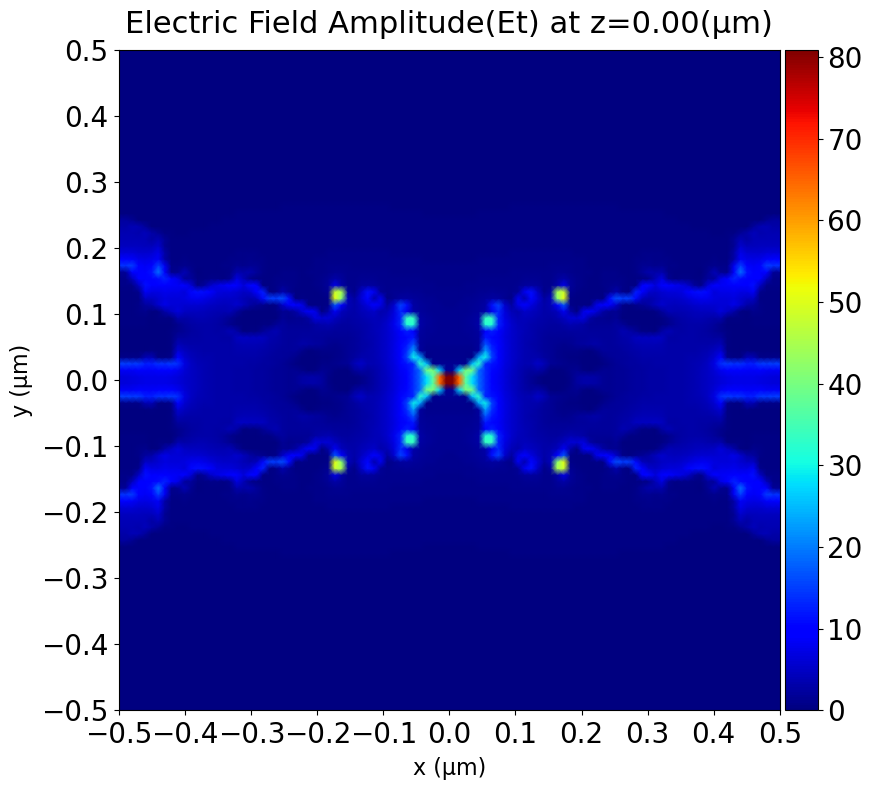

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ================== 參數（字型大小與版面） ==================
TITLE_TEXT       = "Electric Field Amplitude(Et) at z=0.00(μm)"
TITLE_SIZE       = 22     # 標題字體大小
TITLE_PAD        = 12     # 標題與圖的距離

AX_LABEL_SIZE    = 16     # 座標軸標籤字體大小
AX_LABEL_PAD     = 6      # 座標軸標籤與軸的距離

TICK_LABEL_SIZE  = 20     # 座標軸刻度字體大小
TICK_PAD         = 4      # 座標軸刻度文字與軸的距離

CBAR_TICK_SIZE   = 20     # colorbar 刻度字體大小
CBAR_LABEL       = None   # 例如 "|E| enhancement"；不需要就設 None

FIGSIZE          = (10, 8)
CMAP             = "jet"  # 你也可改 'turbo' / 'viridis' 等
VMIN             = 0.0    # 下限；若想自動就設 None
VMAX             = None   # 上限；若想用資料最大值就設 None

X_TICK_START     = -0.5   # x 刻度起點（μm）
X_TICK_STOP      =  0.5   # x 刻度終點（μm）
X_TICK_STEP      =  0.1
Y_TICK_START     = -0.5
Y_TICK_STOP      =  0.5
Y_TICK_STEP      =  0.1

# ================== 資料前處理 ==================
# 期待你已經有 Ex_xyz0, Ey_xyz0, Ez_xyz0（z=0 的切片）以及空腔對照 *_empty
# 若它們尚未存在，請先準備好；以下直接按你原本的定義計算：

amplitude_xyz0       = np.sqrt(np.abs(Ex_xyz0)**2 + np.abs(Ey_xyz0)**2 + np.abs(Ez_xyz0)**2)
amplitude_xyz0_empty = np.sqrt(np.abs(Ex_xyz0_empty)**2 + np.abs(Ey_xyz0_empty)**2 + np.abs(Ez_xyz0_empty)**2)

# 增益（避免除 0）
eps = 1e-12
amplitude_xyz0_enhance = amplitude_xyz0 / (amplitude_xyz0_empty + eps)

# 建立座標（與你原本一致）
x = np.linspace(-Sx/2, Sx/2, Ey_xyz0.shape[0])
y = np.linspace(-Sy/2, Sy/2, Ey_xyz0.shape[1])

# pcolormesh 要求 Z 和 X/Y 尺寸對應；你原本用 transpose，因此維持相同作法
Zplot = np.transpose(amplitude_xyz0_enhance)

# 決定色階範圍
vmin = VMIN if VMIN is not None else 0.0
vmax = VMAX if VMAX is not None else float(np.nanmax(amplitude_xyz0_enhance))

# ================== 繪圖 ==================
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()

pcm = ax.pcolormesh(
    x, y, Zplot,
    cmap=CMAP,
    shading="gouraud",
    vmin=vmin,
    vmax=vmax,
)

ax.set_aspect("equal")

# 標題與座標軸標籤
ax.set_title(TITLE_TEXT, fontsize=TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel("x (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)
ax.set_ylabel("y (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)

# 刻度與字體大小
ax.set_xticks(np.arange(X_TICK_START, X_TICK_STOP + 1e-12, X_TICK_STEP))
ax.set_yticks(np.arange(Y_TICK_START, Y_TICK_STOP + 1e-12, Y_TICK_STEP))
ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE, pad=TICK_PAD)

# colorbar（與主圖等高）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.tick_params(labelsize=CBAR_TICK_SIZE)
if CBAR_LABEL:
    cbar.set_label(CBAR_LABEL, fontsize=AX_LABEL_SIZE, labelpad=6)

plt.tight_layout()
plt.show()
plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


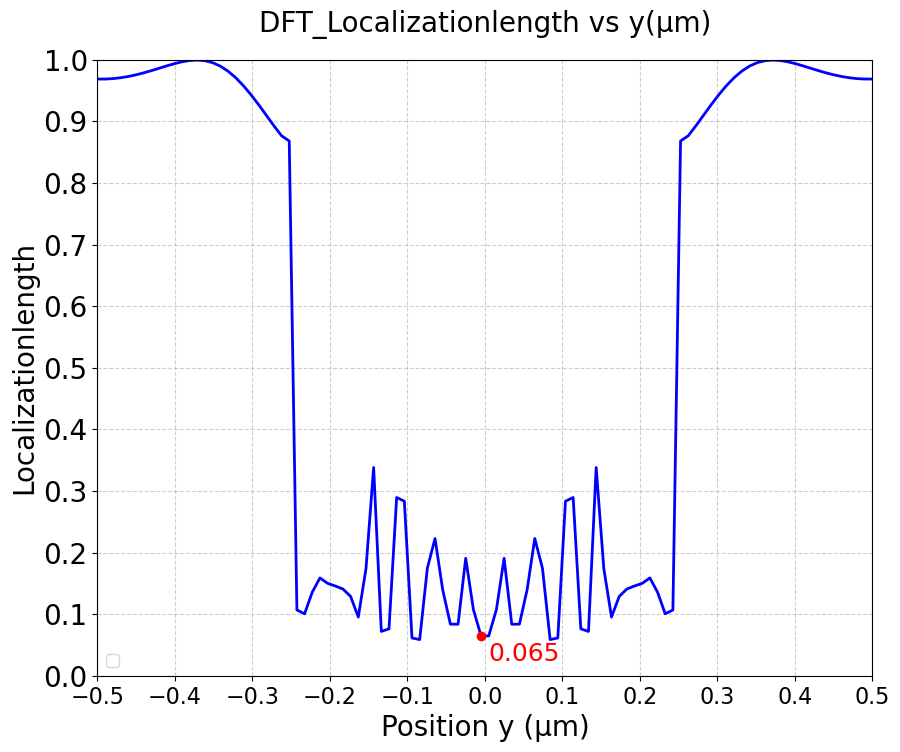

In [13]:
Et_xyz0_4 = np.abs(amplitude_xyz0 )**4
Et_xyz0_2 = np.abs(amplitude_xyz0 )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
y = np.linspace(-Sy/2, Sy/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[1]):
    Ey_4_I = trapezoid(Et_xyz0_4[:,i],x=x)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[1]):
    Ey_2_I = trapezoid(Et_xyz0_2[:,i],x=x)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


y_index = np.argmin(np.abs(y - 0))
y_value = y[y_index]
L_value = L[y_index]

# 繪圖
plt.figure(figsize=(10, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs y(μm)", fontsize=20, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)
plt.plot(y, L, color="blue", linewidth=2, )

# ⬇️ 只標紅點與文字（不加虛線）
plt.scatter(y_value, L_value, color='red', zorder=5)
plt.text(y_value + 0.01, L_value - 0.04, f"{L_value:.3f}", color='red', fontsize=18)

# 座標軸設定
plt.xlim(-0.5, 0.5)
plt.xticks(np.arange(-0.5, 0.5+0.000001 , 0.1), fontsize=16)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1+0.000001 , 0.1), fontsize=20)
plt.xlabel("Position y (μm)", fontsize=20)
plt.ylabel("Localizationlength", fontsize=20)

plt.legend(fontsize=12)
plt.show()
plt.close()
############################################################################







(102, 102, 64)
-0.02087301587301571


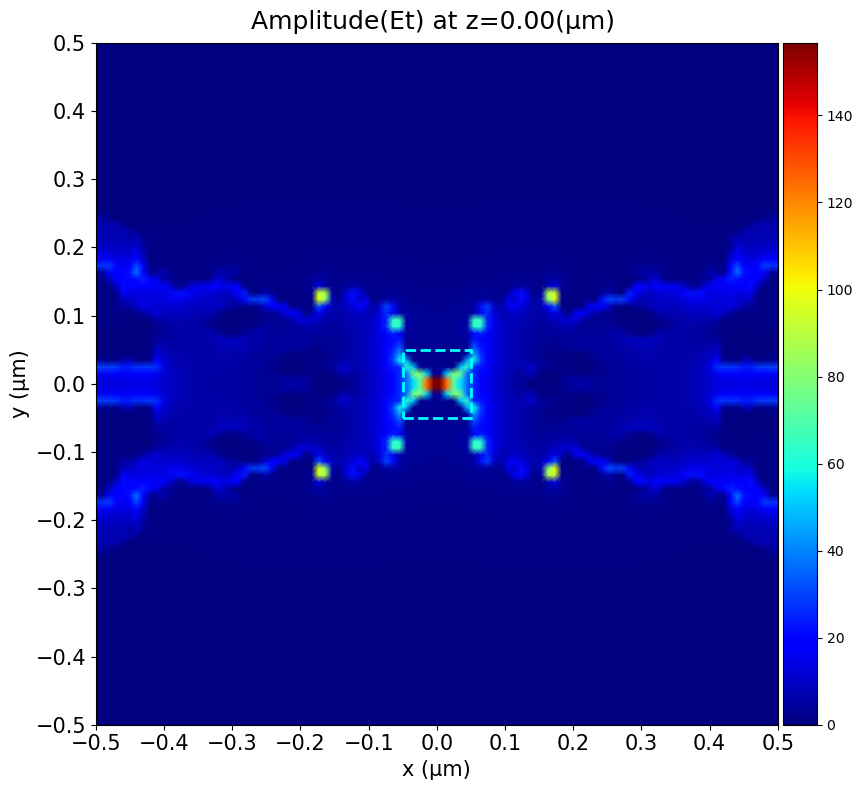

mode volume in center 0.1×0.1×0.4 μm³ region = 0.2235770772245703 μm³


In [14]:

mode_volume  = np.sqrt(np.abs(Ex_mode_volume)**2 + np.abs(Ey_mode_volume)**2 + np.abs(Ez_mode_volume)**2)
#print(mode_volume)
mode_volume_Z0 = mode_volume[:,:,31]
#print(mode_volume_Z0)
print(mode_volume.shape)
####################################################################################################
Nz = mode_volume.shape[2]
z = np.linspace(-Sz/2, Sz/2, Nz)
print(z[31])

x = np.linspace(-Sx/2,Sx/2,mode_volume_Z0.shape[0])
y = np.linspace(-Sy/2,Sy/2,mode_volume_Z0.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        y,
        np.transpose(mode_volume_Z0),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(mode_volume_Z0),
    )

x0 = 0  # 你視覺上選定的中心點
y0 = 0
width = 0.1
height = 0.1

rect = Rectangle((x0 - width/2, y0 - height/2), width, height,
                 edgecolor='cyan', facecolor='none', linewidth=2, linestyle='--')
plt.gca().add_patch(rect)


plt.gca().set_aspect("equal")
plt.title("Amplitude(Et) at z=0.00(μm) ", fontsize=18, pad=10)#fontweight='bold', pad=20)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("y (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.5, 0.5)
plt.yticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()





####################################################################################################
x0 = 0  # μm
y0 = 0 # μm
# 建立實際座標軸
x = np.linspace(-0.5, 0.5, Nx)
y = np.linspace(-0.5, 0.5, Ny)
z = np.linspace(-0.3, 0.3, Nz)  # 對應 shape = 62

# 中心 ±0.05 μm 與 ±0.2 μm 範圍
x_mask = np.logical_and(x >= x0 - 0.5, x <= x0 + 0.5)
y_mask = np.logical_and(y >= y0 - 0.5, y <= y0 + 0.5)
z_mask = np.logical_and(z >= -0.3, z <= 0.3)

#x_mask = np.logical_and(x >= x0 - 0.05, x <= x0 + 0.05)
#y_mask = np.logical_and(y >= y0 - 0.05, y <= y0 + 0.05)
#z_mask = np.logical_and(z >= -0.02, z <= 0.02)

# 裁切座標與資料

x_crop = x[x_mask]
y_crop = y[y_mask]
z_crop = z[z_mask]
mv_crop = mode_volume[np.ix_(x_mask, y_mask, z_mask)]

# 計算 |E|² 與 |E|⁴
Et2 = mv_crop
Et4 = Et2**2

# 三維 trapezoidal 積分
I2 = trapezoid(trapezoid(trapezoid(Et2, x=z_crop, axis=2),
                         x=y_crop, axis=1),
               x=x_crop, axis=0)
I4 = trapezoid(trapezoid(trapezoid(Et4, x=z_crop, axis=2),
                         x=y_crop, axis=1),
               x=x_crop, axis=0)

L_3D = (I2 ** 2) / I4
print("mode volume in center 0.1×0.1×0.4 μm³ region =", L_3D, "μm³")


MAX_FIELD = 156.7255994656918
90.5739391704992
(102, 102)
156.72559946569177


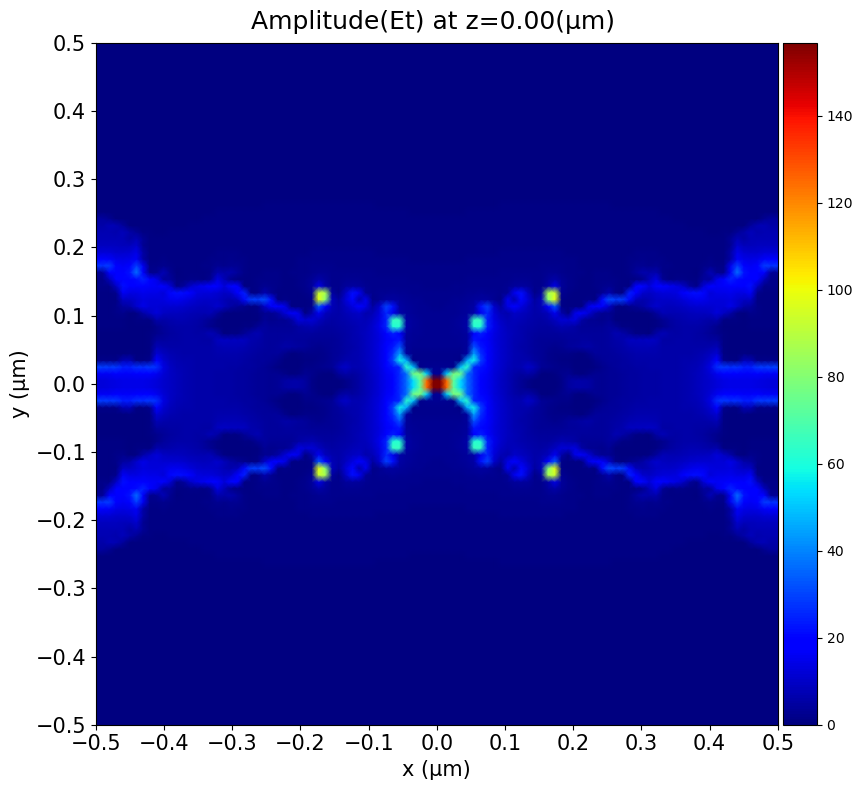

In [15]:
amplitude_xyz0       = np.sqrt(np.abs(Ex_xyz0)**2 + np.abs(Ey_xyz0)**2 + np.abs(Ez_xyz0)**2)
print("MAX_FIELD =", np.amax(amplitude_xyz0))
fom_error = evaluation_history[-1] / (np.sqrt(3))
print(fom_error)
print(amplitude_xyz0.shape)
print(amplitude_xyz0[50,50])
amplitude_xyz0_log   = np.log(amplitude_xyz0 )
amplitude_xyz0_sqrt  = np.sqrt(amplitude_xyz0 ) 

amplitude_xyz0_empty    = np.sqrt(np.abs(Ex_xyz0_empty)**2 + np.abs(Ey_xyz0_empty)**2 + np.abs(Ez_xyz0_empty)**2)
amplitude_xyz0_enhance  = amplitude_xyz0 / amplitude_xyz0_empty
amplitude_xyz0_enhance_log  = np.log(amplitude_xyz0_enhance) 
amplitude_xyz0_enhance_sqrt = np.sqrt(amplitude_xyz0_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_xyz0.shape[0])
y = np.linspace(-Sy/2,Sy/2,Ey_xyz0.shape[1])

################################################################################################################
plt.figure(figsize=(10, 8))

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        y,
        np.transpose(amplitude_xyz0  ),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_xyz0  ),
    )


plt.gca().set_aspect("equal")
plt.title("Amplitude(Et) at z=0.00(μm) ", fontsize=18, pad=10)#fontweight='bold', pad=20)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("y (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.5, 0.5)
plt.yticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()



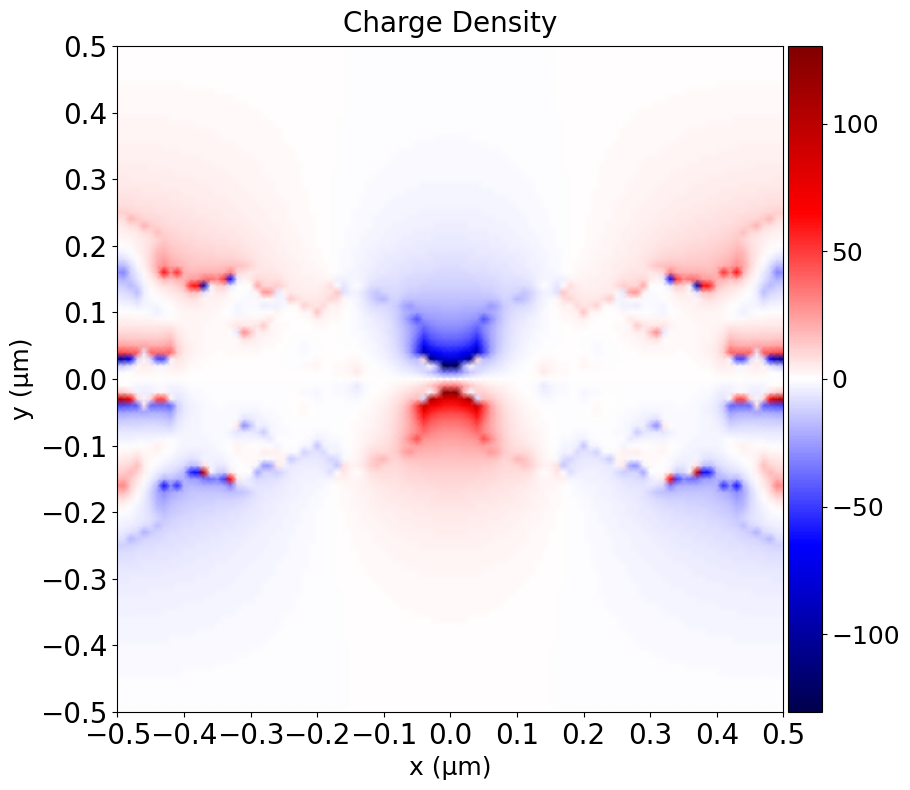

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === 讀取資料 ===
Ez_CD_pos = np.load('DFT_charge_density/DFT_charge_density_Ez_pos.npy')
Ez_CD_neg = np.load('DFT_charge_density/DFT_charge_density_Ez_neg.npy')

# === 計算實部的「電荷密度」場 ===
Ez_CHARGE_real = np.real(Ez_CD_pos) - np.real(Ez_CD_neg)

# === 座標軸（使用你的 Sx、Sy；若未定義請自行替換）===
x = np.linspace(-Sx/2, Sx/2, Ez_CHARGE_real.shape[0])
y = np.linspace(-Sy/2, Sy/2, Ez_CHARGE_real.shape[1])

# === 色軸對稱到 0（適合 seismic/bwr）===
vmax = np.max(np.abs(Ez_CHARGE_real))
vmin = -vmax

# === 繪圖 ===
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.pcolormesh(
    x,
    y,
    np.transpose(Ez_CHARGE_real),
    cmap="seismic",
    shading="gouraud",
    vmin=vmin,
    vmax=vmax,
)

ax.set_aspect("equal")
ax.set_title("Charge Density", fontsize=20, pad=10)
ax.set_xlabel("x (μm)", fontsize=18)
ax.set_ylabel("y (μm)", fontsize=18)
ax.set_ylim(-0.5, 0.5)
ax.set_xticks(np.arange(-0.5, 0.5 + 1e-6, 0.1))
ax.set_yticks(np.arange(-0.5, 0.5 + 1e-6, 0.1))
ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE, pad=TICK_PAD)
#ax.tick_params(axis='both', labelsize=30)

# === colorbar，並更改字體大小 ===
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)

# 調整 colorbar 字體大小（刻度與標籤）
cbar.ax.tick_params(labelsize=18)                 # 刻度字級
# 若有科學記號的 offset（例如 ×1e-3），也調整其字級：
cbar.ax.yaxis.get_offset_text().set_fontsize(30)

plt.tight_layout()
plt.show()
plt.close()


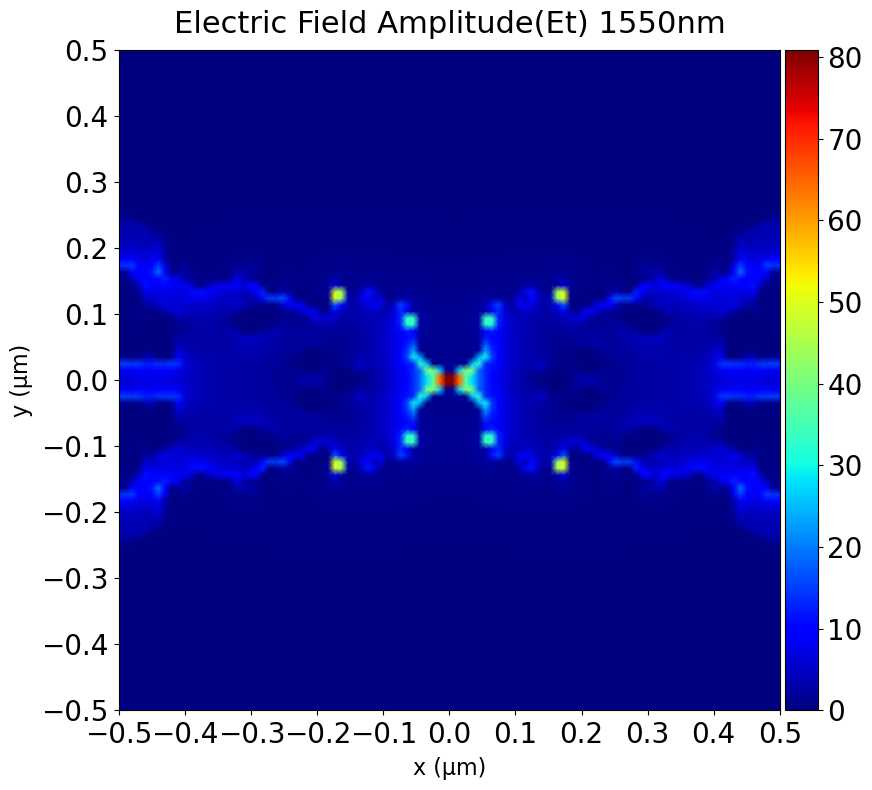

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ================== 參數（字型大小與版面） ==================
TITLE_TEXT       = "Electric Field Amplitude(Et) 1550nm"
TITLE_SIZE       = 22     # 標題字體大小
TITLE_PAD        = 12     # 標題與圖的距離

AX_LABEL_SIZE    = 16     # 座標軸標籤字體大小
AX_LABEL_PAD     = 6      # 座標軸標籤與軸的距離

TICK_LABEL_SIZE  = 20     # 座標軸刻度字體大小
TICK_PAD         = 4      # 座標軸刻度文字與軸的距離

CBAR_TICK_SIZE   = 20     # colorbar 刻度字體大小
CBAR_LABEL       = None   # 例如 "|E| enhancement"；不需要就設 None

FIGSIZE          = (10, 8)
CMAP             = "jet"  # 你也可改 'turbo' / 'viridis' 等
VMIN             = 0.0    # 下限；若想自動就設 None
VMAX             = None   # 上限；若想用資料最大值就設 None

X_TICK_START     = -0.5   # x 刻度起點（μm）
X_TICK_STOP      =  0.5   # x 刻度終點（μm）
X_TICK_STEP      =  0.1
Y_TICK_START     = -0.5
Y_TICK_STOP      =  0.5
Y_TICK_STEP      =  0.1

# ================== 資料前處理 ==================
# 期待你已經有 Ex_xyz0, Ey_xyz0, Ez_xyz0（z=0 的切片）以及空腔對照 *_empty
# 若它們尚未存在，請先準備好；以下直接按你原本的定義計算：

amplitude_xyz0       = np.sqrt(np.abs(Ex_xyz0)**2 + np.abs(Ey_xyz0)**2 + np.abs(Ez_xyz0)**2)
amplitude_xyz0_empty = np.sqrt(np.abs(Ex_xyz0_empty)**2 + np.abs(Ey_xyz0_empty)**2 + np.abs(Ez_xyz0_empty)**2)

# 增益（避免除 0）
eps = 1e-12
amplitude_xyz0_enhance = amplitude_xyz0 / (amplitude_xyz0_empty + eps)

# 建立座標（與你原本一致）
x = np.linspace(-Sx/2, Sx/2, Ey_xyz0.shape[0])
y = np.linspace(-Sy/2, Sy/2, Ey_xyz0.shape[1])

# pcolormesh 要求 Z 和 X/Y 尺寸對應；你原本用 transpose，因此維持相同作法
Zplot = np.transpose(amplitude_xyz0_enhance)

# 決定色階範圍
vmin = VMIN if VMIN is not None else 0.0
vmax = VMAX if VMAX is not None else float(np.nanmax(amplitude_xyz0_enhance))

# ================== 繪圖 ==================
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()

pcm = ax.pcolormesh(
    x, y, Zplot,
    cmap=CMAP,
    shading="gouraud",
    vmin=vmin,
    vmax=vmax,
)

ax.set_aspect("equal")

# 標題與座標軸標籤
ax.set_title(TITLE_TEXT, fontsize=TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel("x (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)
ax.set_ylabel("y (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)

# 刻度與字體大小
ax.set_xticks(np.arange(X_TICK_START, X_TICK_STOP + 1e-12, X_TICK_STEP))
ax.set_yticks(np.arange(Y_TICK_START, Y_TICK_STOP + 1e-12, Y_TICK_STEP))
ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE, pad=TICK_PAD)

# colorbar（與主圖等高）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.tick_params(labelsize=CBAR_TICK_SIZE)
if CBAR_LABEL:
    cbar.set_label(CBAR_LABEL, fontsize=AX_LABEL_SIZE, labelpad=6)

plt.tight_layout()
plt.show()
plt.close()


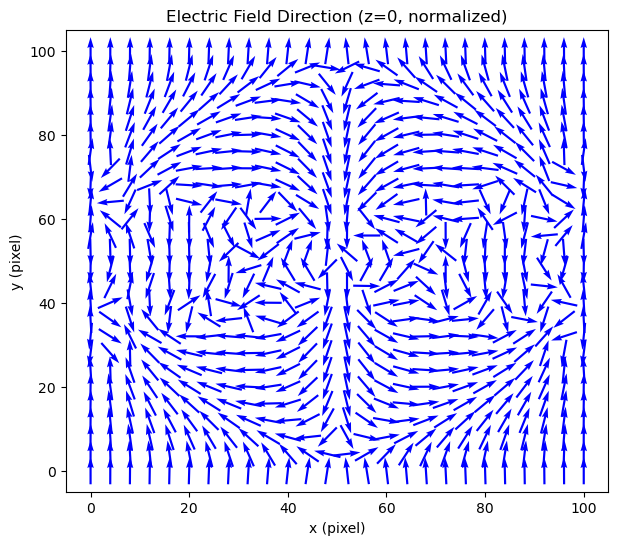

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 讀檔
Ex = np.load('DFT_GAS/Dft_GAS_Ex_xyz0.npy')
Ey = np.load('DFT_GAS/Dft_GAS_Ey_xyz0.npy')
Ez = np.load('DFT_GAS/Dft_GAS_Ez_xyz0.npy')

# ------ 相位對齊 ------
Emag2 = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2
i0, j0 = np.unravel_index(np.argmax(Emag2), Emag2.shape)
phi0 = np.angle(Ex[i0, j0] + Ey[i0, j0] + Ez[i0, j0])
rot = np.exp(-1j * phi0)

Exr, Eyr = Ex*rot, Ey*rot

# ------ 單位化 (只要方向，不要強度) ------
U = np.real(Exr)
V = np.real(Eyr)
norm = np.sqrt(U**2 + V**2) + 1e-12   # 避免除以零
Uu, Vu = U/norm, V/norm

# ------ 建立座標 ------
nx, ny = U.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# ------ 下採樣避免太密 ------
step = 4
plt.figure(figsize=(7,6))
plt.quiver(X[::step, ::step], Y[::step, ::step],
           Uu[::step, ::step], Vu[::step, ::step],
           color="blue", scale=20, pivot="mid", width=0.004)

plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("Electric Field Direction (z=0, normalized)")
plt.show()


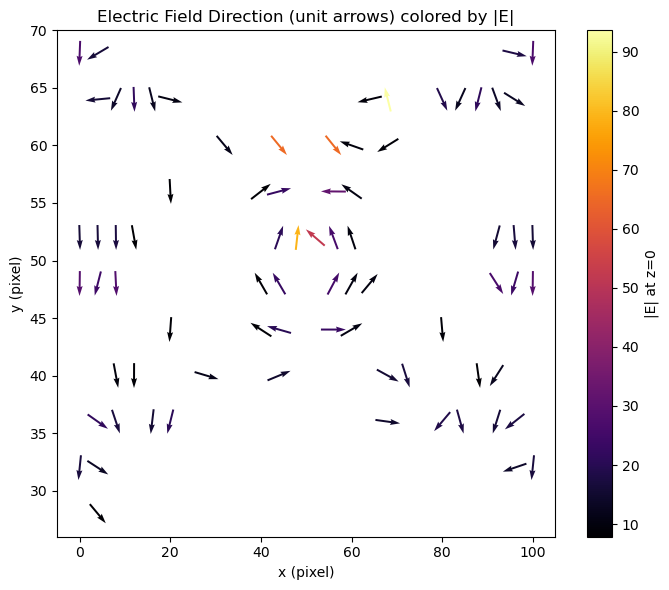

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# --- 讀檔 ---
Ex = np.load('DFT_GAS/Dft_GAS_Ex_xyz0.npy')  # complex
Ey = np.load('DFT_GAS/Dft_GAS_Ey_xyz0.npy')
Ez = np.load('DFT_GAS/Dft_GAS_Ez_xyz0.npy')
Dx = np.load('DFT_GAS/Dft_GAS_Dx_xyz0.npy')  # complex
Dy = np.load('DFT_GAS/Dft_GAS_Dy_xyz0.npy')
Dz = np.load('DFT_GAS/Dft_GAS_Dz_xyz0.npy')

# --- 全域相位對齊（用最大 |E| 的點當參考） ---
Emag2_full = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2
i0, j0 = np.unravel_index(np.argmax(Emag2_full), Emag2_full.shape)
phi0 = np.angle(Ex[i0, j0] + Ey[i0, j0] + Ez[i0, j0] + 1e-30)
rot = np.exp(-1j * phi0)
Exr, Eyr, Ezr = Ex*rot, Ey*rot, Ez*rot

# --- 箭頭方向（取實部 → 單位化） ---
U = np.real(Exr)
V = np.real(Eyr)
norm = np.sqrt(U**2 + V**2) + 1e-20
Uu, Vu = U / norm, V / norm  # 單位方向

# --- 場強度（用來著色；建議用 |E| = sqrt(|Ex|^2+|Ey|^2+|Ez|^2)）---
Emag = np.sqrt(np.abs(Exr)**2 + np.abs(Eyr)**2 + np.abs(Ezr)**2)

# --- 座標網格（若你有實際尺寸，改成 linspace(xmin,xmax,...)）---
nx, ny = U.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# --- 下採樣 + 強度遮罩（讓箭頭不擁擠、弱訊號不畫）---
step = 4                               # 箭頭間距，視資料調整
th = 0.05 * Emag.max()                 # 只畫 >= 5% 峰值的點，可改 0~0.2
mask = Emag >= th

Xq = X[::step, ::step][mask[::step, ::step]]
Yq = Y[::step, ::step][mask[::step, ::step]]
Uq = Uu[::step, ::step][mask[::step, ::step]]
Vq = Vu[::step, ::step][mask[::step, ::step]]
Cq = Emag[::step, ::step][mask[::step, ::step]]  # 顏色 = 強度

# --- 顏色刻度（線性 or 對數，擇一）---
use_log_color = False
if use_log_color:
    # 對數色標（動態範圍大時更清楚）
    norm_c = colors.LogNorm(vmin=max(Cq.min(), 1e-6), vmax=Cq.max())
else:
    # 線性色標
    norm_c = None

# --- 繪圖（只有箭頭；顏色表示 |E| 強度）---
plt.figure(figsize=(7,6))
Q = plt.quiver(
    Xq, Yq, Uq, Vq,
    Cq,                      # 用強度上色
    cmap='inferno',
    norm=norm_c,
    pivot='mid',
    scale=20,                # 調整箭頭視覺長度（與場強無關）
    width=0.004
)
cbar = plt.colorbar(Q)
cbar.set_label('|E| at z=0')

plt.xlabel('x (pixel)')  # 有實際尺寸就改成 μm
plt.ylabel('y (pixel)')
plt.title('Electric Field Direction (unit arrows) colored by |E|')
plt.tight_layout()
plt.show()


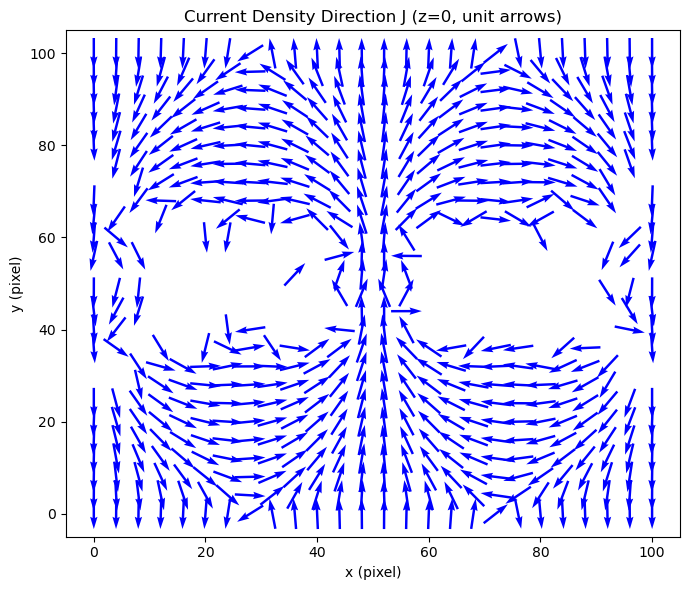

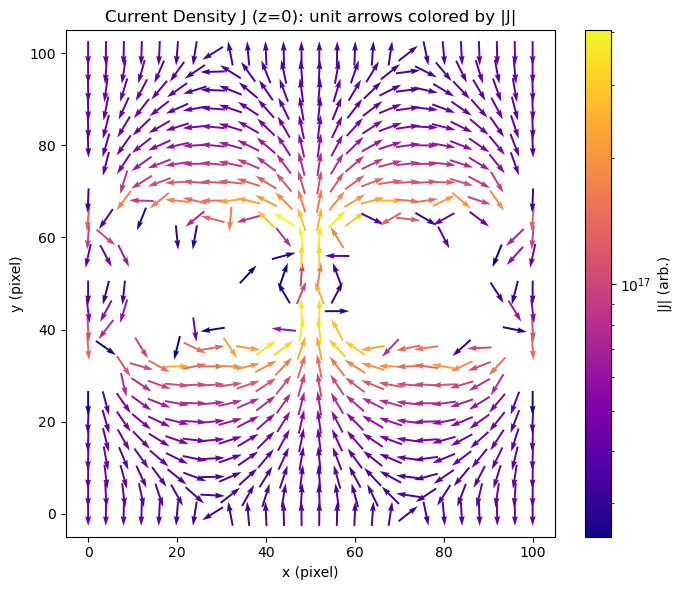

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# ---- 讀入 z=0 的 DFT 場（複數）----
Ex = np.load('DFT_GAS/Dft_GAS_Ex_xyz0.npy')  # complex
Ey = np.load('DFT_GAS/Dft_GAS_Ey_xyz0.npy')
Ez = np.load('DFT_GAS/Dft_GAS_Ez_xyz0.npy')
Dx = np.load('DFT_GAS/Dft_GAS_Dx_xyz0.npy')  # complex
Dy = np.load('DFT_GAS/Dft_GAS_Dy_xyz0.npy')
Dz = np.load('DFT_GAS/Dft_GAS_Dz_xyz0.npy')

# ---- 物理常數與角頻率 ω ----
eps0 = 8.854187817e-12  # F/m
c0   = 299792458.0      # m/s
lam0 = 1.55e-6          # 你的工作波長（依實際修改）
omega = 2*np.pi*c0/lam0

# ---- J(ω) = -i ω (D - eps0 E) ----
Jx = -1j*omega*(Dx - eps0*Ex)
Jy = -1j*omega*(Dy - eps0*Ey)
Jz = -1j*omega*(Dz - eps0*Ez)

# （可選）全域相位對齊，讓取實部的方向穩定
Jmag2 = np.abs(Jx)**2 + np.abs(Jy)**2 + np.abs(Jz)**2
i0, j0 = np.unravel_index(np.argmax(Jmag2), Jmag2.shape)
phi0 = np.angle(Jx[i0, j0] + Jy[i0, j0] + Jz[i0, j0] + 1e-30)
rot = np.exp(-1j*phi0)
Jx_r, Jy_r = np.real(Jx*rot), np.real(Jy*rot)

# ---- 單位化方向（只要方向的箭頭）----
norm = np.sqrt(Jx_r**2 + Jy_r**2) + 1e-20
Ux, Uy = Jx_r/norm, Jy_r/norm

# ---- 可視化參數 ----
nx, ny = Ux.shape
x = np.arange(nx); y = np.arange(ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# 只在 |J| 夠大的地方畫箭頭，避免噪聲
Jabs = np.sqrt(Jmag2)
th = 0.05 * Jabs.max()
mask = (Jabs >= th)

step = 4  # 下採樣疏密
Xq = X[::step, ::step][mask[::step, ::step]]
Yq = Y[::step, ::step][mask[::step, ::step]]
Uq = Ux[::step, ::step][mask[::step, ::step]]
Vq = Uy[::step, ::step][mask[::step, ::step]]
Cq = Jabs[::step, ::step][mask[::step, ::step]]  # 用 |J| 上色（可拿掉）

# ---- (A) 只畫方向（不著色）----
plt.figure(figsize=(7,6))
plt.quiver(Xq, Yq, Uq, Vq, color='blue', pivot='mid', scale=20, width=0.004)
plt.xlabel('x (pixel)'); plt.ylabel('y (pixel)')
plt.title('Current Density Direction J (z=0, unit arrows)')
plt.tight_layout(); plt.show()

# ---- (B) 用 |J| 當箭頭顏色（動態範圍大時可用 LogNorm）----
plt.figure(figsize=(7,6))
Q = plt.quiver(Xq, Yq, Uq, Vq, Cq, cmap='plasma',
               norm=colors.LogNorm(vmin=max(Cq.min(), 1e-12), vmax=Cq.max()),
               pivot='mid', scale=20, width=0.004)
plt.colorbar(Q, label='|J| (arb.)')
plt.xlabel('x (pixel)'); plt.ylabel('y (pixel)')
plt.title('Current Density J (z=0): unit arrows colored by |J|')
plt.tight_layout(); plt.show()


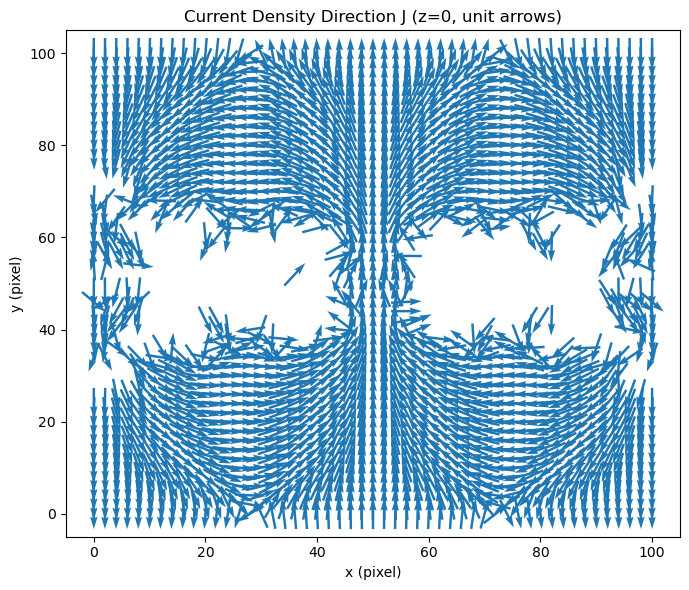

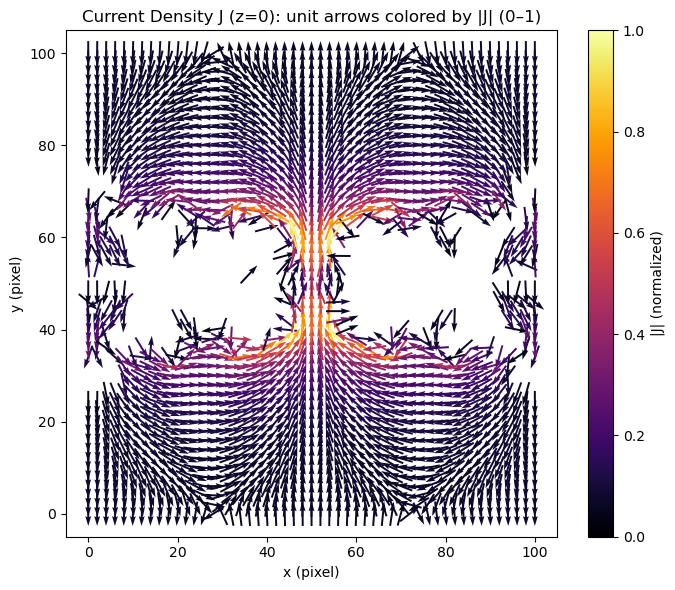

[info] 找不到 eps_data 檔案，略過結構疊圖（如果需要，請輸出/存成 npy 再重新執行）。


In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# ========================
# 0) 使用者設定（請依實際檔名/尺寸修改）
# ========================

# 必要：E、D 的 z=0 截面（複數 DFT 場）
Ex_path = 'DFT_GAS/Dft_GAS_Ex_xyz0.npy'
Ey_path = 'DFT_GAS/Dft_GAS_Ey_xyz0.npy'
Ez_path = 'DFT_GAS/Dft_GAS_Ez_xyz0.npy'
Dx_path = 'DFT_GAS/Dft_GAS_Dx_xyz0.npy'   # <--- 請確保你有輸出 D 分量
Dy_path = 'DFT_GAS/Dft_GAS_Dy_xyz0.npy'
Dz_path = 'DFT_GAS/Dft_GAS_Dz_xyz0.npy'

# 可選：結構介電常數分布（與同一截面/尺寸對齊）
eps_path = 'DFT_GAS/eps_xyz0.npy'  # 若沒有此檔，程式會自動略過疊圖

# 工作波長 (公尺)；用你的實際值
lam0 = 1.55e-6

# 是否用「物理座標」對齊（單位同你模擬，如 µm）
# 若你知道截面實際寬高，填進去；不知則設 use_physical_coords=False 用像素座標
use_physical_coords = False
physical_width_x = 1.0    # 例：整張圖 x 寬 1.0 μm
physical_height_y = 1.0   # 例：整張圖 y 高 1.0 μm

# 箭頭下採樣與強度門檻
downsample_step = None     # None 會自動取約 40×40 的箭頭密度；或填入整數 (如 4/6/8)
strength_threshold = 0.05  # 只畫 |J| >= 5% 峰值的點；可調 0~0.2

# ========================
# 1) 讀檔
# ========================
Ex = np.load(Ex_path); Ey = np.load(Ey_path); Ez = np.load(Ez_path)
Dx = np.load(Dx_path); Dy = np.load(Dy_path); Dz = np.load(Dz_path)

assert Ex.shape == Ey.shape == Ez.shape == Dx.shape == Dy.shape == Dz.shape, "E/D 陣列尺寸需一致"

nx, ny = Ex.shape

# ========================
# 2) 常數、角頻率
# ========================
eps0 = 8.854187817e-12  # F/m
c0   = 299792458.0      # m/s
omega = 2*np.pi*c0/lam0

# ========================
# 3) 計算 J = -i ω (D - eps0 E)
# ========================
Jx = -1j*omega*(Dx - eps0*Ex)
Jy = -1j*omega*(Dy - eps0*Ey)
Jz = -1j*omega*(Dz - eps0*Ez)

# ========================
# 4) 全域相位對齊 → 取實部（方向穩定）
# ========================
Jmag2 = np.abs(Jx)**2 + np.abs(Jy)**2 + np.abs(Jz)**2
i0, j0 = np.unravel_index(np.argmax(Jmag2), Jmag2.shape)
phi0 = np.angle(Jx[i0, j0] + Jy[i0, j0] + Jz[i0, j0] + 1e-30)
rot = np.exp(-1j*phi0)

Jx_r = np.real(Jx * rot)
Jy_r = np.real(Jy * rot)

# ========================
# 5) 方向單位化 & 強度（0-1 正規化）
# ========================
norm = np.sqrt(Jx_r**2 + Jy_r**2) + 1e-20
Ux = Jx_r / norm
Uy = Jy_r / norm

Jabs = np.sqrt(Jmag2)              # 原始 |J|
Jabs_norm = Jabs / (Jabs.max() + 1e-30)  # 0~1 正規化

# ========================
# 6) 座標網格（像素 or 物理）
# ========================
if use_physical_coords:
    x = np.linspace(-physical_width_x/2,  physical_width_x/2,  nx)
    y = np.linspace(-physical_height_y/2, physical_height_y/2, ny)
    xlab, ylab = 'x (µm)', 'y (µm)'
else:
    x = np.arange(nx)
    y = np.arange(ny)
    xlab, ylab = 'x (pixel)', 'y (pixel)'

X, Y = np.meshgrid(x, y, indexing='ij')

# ========================
# 7) 強度門檻 & 下採樣
# ========================
mask = (Jabs >= (strength_threshold * Jabs.max()))
if downsample_step is None:
    # 讓箭頭大約不超過 ~40x40
    downsample_step = max(1, min(nx, ny) // 40)

Xq = X[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Yq = Y[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Uq = Ux[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Vq = Uy[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Cq = Jabs_norm[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]

# ========================
# 8A) 只有方向（不著色）
# ========================
plt.figure(figsize=(7,6))
plt.quiver(Xq, Yq, Uq, Vq, color='tab:blue', pivot='mid', scale=20, width=0.004)
plt.xlabel(xlab); plt.ylabel(ylab)
plt.title('Current Density Direction J (z=0, unit arrows)')
plt.tight_layout()
plt.show()

# ========================
# 8B) 方向＋顏色（|J| 正規化 0–1）
# ========================
plt.figure(figsize=(7,6))
Q = plt.quiver(
    Xq, Yq, Uq, Vq, Cq,
    cmap='inferno', norm=colors.Normalize(vmin=0.0, vmax=1.0),
    pivot='mid', scale=20, width=0.004
)
cbar = plt.colorbar(Q); cbar.set_label('|J| (normalized)')
plt.xlabel(xlab); plt.ylabel(ylab)
plt.title('Current Density J (z=0): unit arrows colored by |J| (0–1)')
plt.xlim()
plt.tight_layout()
plt.show()

# ========================
# 9) （可選）把結構疊成底圖（若有 eps_data 檔就疊；沒有則略過）
# ========================
try:
    eps_data = np.load(eps_path)  # 建議這是與同一截面對齊的實部 ε
    if eps_data.shape != (nx, ny):
        print(f"[warn] eps_data shape {eps_data.shape} != field shape {(nx, ny)}，略過疊圖。")
    else:
        plt.figure(figsize=(7,6))
        # 底圖：結構（灰階、半透明）
        plt.imshow(
            np.real(eps_data).T, origin='lower',
            extent=[x.min(), x.max(), y.min(), y.max()],
            cmap='Greys', alpha=0.5
        )
        # 疊 J 的箭頭（顏色 0–1）
        Q2 = plt.quiver(
            Xq, Yq, Uq, Vq, Cq,
            cmap='inferno', norm=colors.Normalize(vmin=0.0, vmax=1.0),
            pivot='mid', scale=20, width=0.004
        )
        cbar2 = plt.colorbar(Q2); cbar2.set_label('|J| (normalized)')
        plt.xlabel(xlab); plt.ylabel(ylab)
        plt.title('J on Structure (z=0): unit arrows colored by |J| (0–1)')
        plt.tight_layout()
        plt.show()
except FileNotFoundError:
    print("[info] 找不到 eps_data 檔案，略過結構疊圖（如果需要，請輸出/存成 npy 再重新執行）。")


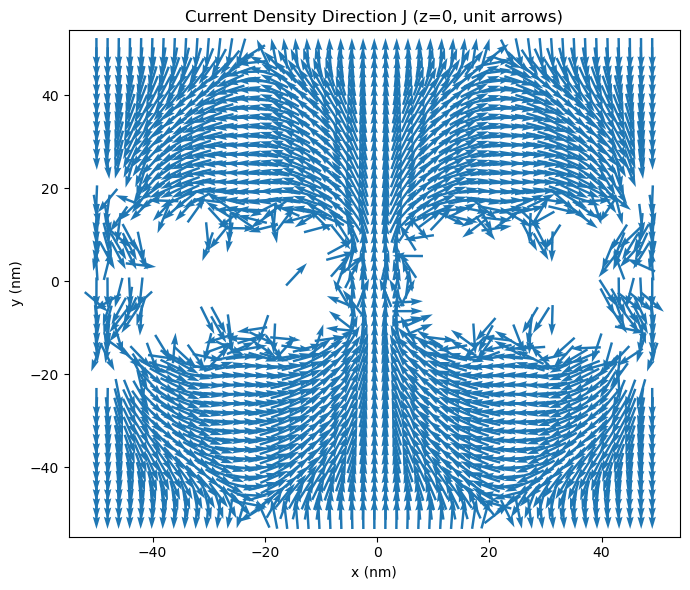

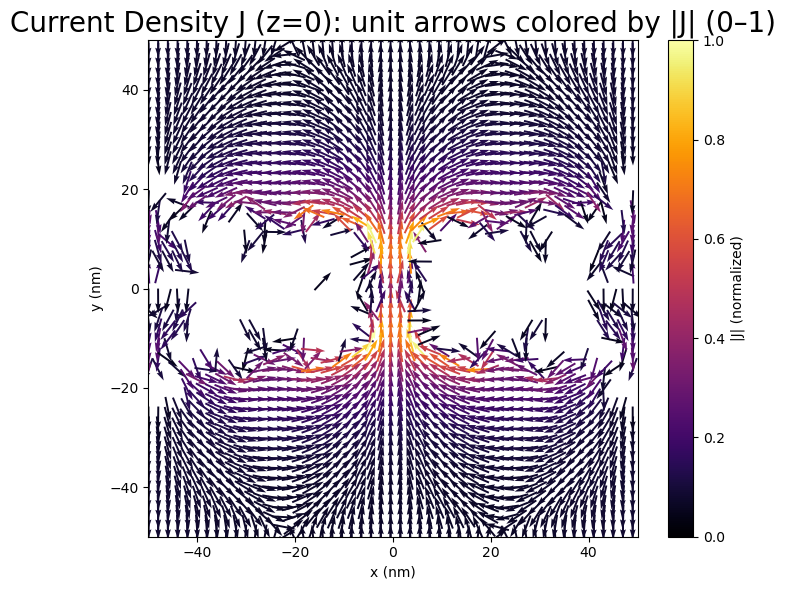

[info] 找不到 eps_xyz0.npy，略過結構疊圖。


In [11]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# ========= 路徑設定（依你的檔名調整） =========
Ex_path = 'DFT_GAS/Dft_GAS_Ex_xyz0.npy'
Ey_path = 'DFT_GAS/Dft_GAS_Ey_xyz0.npy'
Ez_path = 'DFT_GAS/Dft_GAS_Ez_xyz0.npy'
Dx_path = 'DFT_GAS/Dft_GAS_Dx_xyz0.npy'   # 確保已輸出 D
Dy_path = 'DFT_GAS/Dft_GAS_Dy_xyz0.npy'
Dz_path = 'DFT_GAS/Dft_GAS_Dz_xyz0.npy'
eps_path = 'DFT_GAS/eps_xyz0.npy'         # 可選：若無此檔會自動略過

# ========= 物理參數 =========
lam0 = 1.55e-6           # 工作波長 (m)，依需要修改
eps0 = 8.854187817e-12   # F/m
c0   = 299792458.0       # m/s
omega = 2*np.pi*c0/lam0

# ========= 讀檔 =========
Ex = np.load(Ex_path); Ey = np.load(Ey_path); Ez = np.load(Ez_path)
Dx = np.load(Dx_path); Dy = np.load(Dy_path); Dz = np.load(Dz_path)

assert Ex.shape == Ey.shape == Ez.shape == Dx.shape == Dy.shape == Dz.shape, "E/D 尺寸需一致"
nx, ny = Ex.shape

# ========= 計算 J(ω) =========
Jx = -1j*omega*(Dx - eps0*Ex)
Jy = -1j*omega*(Dy - eps0*Ey)
Jz = -1j*omega*(Dz - eps0*Ez)

# ========= 全域相位對齊（讓取實部的方向穩定） =========
Jmag2 = np.abs(Jx)**2 + np.abs(Jy)**2 + np.abs(Jz)**2
i0, j0 = np.unravel_index(np.argmax(Jmag2), Jmag2.shape)
phi0 = np.angle(Jx[i0, j0] + Jy[i0, j0] + Jz[i0, j0] + 1e-30)
rot = np.exp(-1j*phi0)
Jx_r = np.real(Jx * rot)
Jy_r = np.real(Jy * rot)

# ========= 單位化方向 + |J| 正規化 =========
norm = np.sqrt(Jx_r**2 + Jy_r**2) + 1e-20
Ux = Jx_r / norm
Uy = Jy_r / norm
Jabs = np.sqrt(Jmag2)
Jabs_norm = Jabs / (Jabs.max() + 1e-30)  # 0~1

# ========= 座標軸：-50 nm ~ +50 nm =========
x = np.linspace(-50.0, 50.0, nx)   # 單位：nm
y = np.linspace(-50.0, 50.0, ny)   # 單位：nm
X, Y = np.meshgrid(x, y, indexing='ij')

# ========= 強度門檻與下採樣（避免太密 & 雜訊） =========
strength_threshold = 0.05                 # 只畫 >= 5% 峰值
mask = (Jabs >= (strength_threshold * Jabs.max()))

downsample_step = max(1, min(nx, ny) // 40)  # ~40x40 箭頭密度
Xq = X[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Yq = Y[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Uq = Ux[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Vq = Uy[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]
Cq = Jabs_norm[::downsample_step, ::downsample_step][mask[::downsample_step, ::downsample_step]]

# ========= (A) 只有方向（不著色） =========
plt.figure(figsize=(7,6))
plt.quiver(Xq, Yq, Uq, Vq, color='tab:blue', pivot='mid', scale=20, width=0.004)
plt.xlabel('x (nm)'); plt.ylabel('y (nm)')
plt.title('Current Density Direction J (z=0, unit arrows)')
plt.tight_layout(); plt.show()

# ========= (B) 方向 + |J| 著色（0–1） =========
plt.figure(figsize=(7,6))
Q = plt.quiver(
    Xq, Yq, Uq, Vq, Cq,
    cmap='inferno', norm=colors.Normalize(vmin=0.0, vmax=1.0),
    pivot='mid', scale=20, width=0.004
)
cbar = plt.colorbar(Q); cbar.set_label('|J| (normalized)')
plt.xlabel('x (nm)'); plt.ylabel('y (nm)')
plt.title('Current Density J (z=0): unit arrows colored by |J| (0–1)',fontsize=20)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.tight_layout(); plt.show()

# ========= (C) 可選：疊結構底圖（若有 eps_xyz0.npy，需與同一截面/網格對齊） =========
try:
    eps_data = np.load(eps_path)  # 建議是實部 ε(r)
    if eps_data.shape == (nx, ny):
        plt.figure(figsize=(7,6))
        # 結構底圖（灰階、半透明）
        plt.imshow(np.real(eps_data).T, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()],
                   cmap='Greys', alpha=0.5)
        # 疊 J 的箭頭（著色 0–1）
        Q2 = plt.quiver(
            Xq, Yq, Uq, Vq, Cq,
            cmap='inferno', norm=colors.Normalize(vmin=0.0, vmax=1.0),
            pivot='mid', scale=20, width=0.004
        )
        cbar2 = plt.colorbar(Q2); cbar2.set_label('|J| (normalized)')
        plt.xlabel('x (nm)'); plt.ylabel('y (nm)')
        plt.title('J on Structure (z=0): unit arrows colored by |J| (0–1)')
        plt.tight_layout(); plt.show()
    else:
        print(f"[warn] eps_data shape {eps_data.shape} != {(nx, ny)}，略過結構疊圖。")
except FileNotFoundError:
    print("[info] 找不到 eps_xyz0.npy，略過結構疊圖。")
